In [1]:
import random
import copy
import numpy as np
import theano as T
import theano.tensor as tt
import pymc3 as pm
import pandas as pd
import rpy2
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%%capture  --no-stderr --no-stdout --no-display
%%R

library(ggplot2)
library(reshape)
library(grid)
library(dplyr)
library(gridExtra)
library(lme4)

paper_theme_2 <- theme_light() + theme(axis.title.x = element_text(size=18),
  axis.text.x=element_text(colour="black", 
                           size = 14), 
  axis.title.y = element_text(size = 18, vjust = 1),
  axis.text.y  = element_text(size = 14, colour="black"),
 title =element_text(size=16, face='bold'))

paper_theme_3 <- theme( axis.title.x = element_text(size=18),
  axis.text.x=element_text(colour="black", 
                           size = 14), 
  axis.title.y = element_text(size = 18, vjust = 1),
  axis.text.y  = element_text(size = 14),
  strip.text=element_text(size=16),
  axis.line.x = element_line(colour = "black"), 
  axis.line.y = element_line(colour = "black"),
  legend.title=element_text(size=18),
  legend.text=element_text(size=16))  

  

/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following object is masked from ‘package:reshape’:

    rename


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘gridExtra’


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145:

In [3]:
%%R --o data_resp
data_resp_loc <- read.csv("r_data/r_resp_425.csv")

#data_resp_loc <- read.csv("data/estimation_dot_gaze.csv", sep="\t")
data_tracker <- read.csv("data/estimation_tracker_data.csv", sep="\t")
data_tracker$trial_id <- data_tracker$trial_id - 1
data_resp_loc$trial_id <- data_resp_loc$trial_id - 1


data_resp_loc <- data_resp_loc %>%
                filter(belowX >=0) 
                #mutate(belowX=max(0.1,belowX))

trials <- (unique(data_resp_loc$trial_id))

data_tracker <- data_tracker %>%
                group_by(trial_id) %>%
                filter(trial_id %in% trials)


data_resp_loc$id <- seq.int(1, nrow(data_resp_loc))
print(head(data_resp_loc))

data_resp <- data_resp_loc %>%
      filter(gazeDist > 0 & Dots_Shown < 150 & Dots_Shown >= 10) %>%
             mutate(Subject=as.factor(Subject)) %>%

            group_by(Time) %>%
            #mutate(Time = as.factor(round(Time, 2))) %>%
             group_by(Subject,trial_id) %>%
             mutate(mean_dist=mean(mean_dist)) %>%

             mutate(n_in_fovea = (p_foveal > 1) )%>%
             mutate(belowX=mean(n_in_fovea)) %>%
             mutate(n_within_gaze = sum(n_in_fovea)) %>%
             mutate(p_within_gaze = n_within_gaze/Dots_Shown) %>%
            mutate(time_num = as.numeric(as.character(Time))) %>%
            mutate(err=Dots_Counted-Dots_Shown) %>%
              mutate(pct_err=err/Dots_Shown) %>%
             mutate(within_x=p_within_gaze) %>%
            mutate(within_x_tot=n_within_gaze)%>%
            mutate(fix_PL = mean(fix_PL)) %>%
            mutate(area=mean(area)) %>%
             top_n(n=1, wt=id) %>%
            group_by(Time) %>%
         filter((pct_err < 2)) %>%
            group_by(Subject) %>%
            mutate(mean_fix_PL = mean(fix_PL)) %>%
          mutate(pathLength=mean(fix_PL)) %>%
          mutate(medFix = mean(medFix)) %>%
          mutate(mean_PL=mean(fix_PL)) %>%
          mutate(mean_area=mean(area)) %>%
          #mutate(mean_dist=sum(gazeDist)/Dots_Shown) %>%
          mutate(err=Dots_Counted - Dots_Shown) %>%
          mutate(abs_err=abs(err)) %>%
          mutate(mean_abs_err = mean(abs_err)) %>%
          mutate(pct_err=err/Dots_Shown) %>%
            mutate(abs_pct_err=abs_err/Dots_Shown) %>%
         # filter(abs_pct_err <= 1.) %>%
          #group_by(Subject, pid)%>%
          #filter(length(Subject) > 0)  %>%
          group_by(Subject, pid, Time) %>%
          #  mutate(outlier= mean(mean_dist) + 2.5*sd(mean_dist)) %>%

          mutate(n_seen = n())# %>%
           # rowwise() %>%
          #  filter(mean_dist < outlier)
         #filter(Time == 0.1)
print(nrow(data_resp))


data_tracker <- data_tracker %>%
                  filter(ValidityLeft == 0 & ValidityRight == 0) %>%

                mutate(av_x = (GazePointXLeft +GazePointXRight)/2) %>%
                mutate(av_y = (GazePointYLeft +GazePointYRight)/2) %>%
                group_by(trial_id) %>%
                mutate(Time = round(max(TimeStamp)/100)/10)

data_tracker$id <- seq.int(1,nrow(data_tracker))

data_resp$Time <- as.factor(round(data_resp$Time,2))

print(table(data_resp$pid, data_resp$n_seen))




  X pid trial_id Subject Session Trial      Time Trial_Start  Trial_End
1 0   0        0     rup       2     0 0.3333333  1532462038 1532462038
2 1   0        0     rup       2     0 0.3333333  1532462038 1532462038
3 2   0        0     rup       2     0 0.3333333  1532462038 1532462038
4 3   0        0     rup       2     0 0.3333333  1532462038 1532462038
5 4   0        0     rup       2     0 0.3333333  1532462038 1532462038
6 5   0        0     rup       2     0 0.3333333  1532462038 1532462038
  Dots_Shown Dots_Counted     Score Dot_Width Dot_Height dl_x dl_y    gazeX
1         18           20 0.8888889         8          8  624  491 958.1457
2         18           20 0.8888889         8          8 1582  206 975.9689
3         18           20 0.8888889         8          8 1206  777 975.4523
4         18           20 0.8888889         8          8  138  896 953.6928
5         18           20 0.8888889         8          8  685  764 953.6928
6         18           20 0.8888889     

In [4]:
%%R

p.1 <- ggplot(data=data_resp, aes(x=area, y=pct_err, color=Time)) +
        geom_point() +
        stat_smooth(method="lm") +
        paper_theme_2
        
r.1 <- lm(data=data_resp, pct_err ~ p_within_gaze*time_num)
r.2 <- lm(data=data_resp, pct_err ~ p_within_gaze+Dots_Shown)

print(summary(r.1))
print(summary(r.2))



Call:
lm(formula = pct_err ~ p_within_gaze * time_num, data = data_resp)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.57546 -0.19359 -0.03784  0.13355  1.76502 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)            -0.31278    0.02761 -11.329   <2e-16 ***
p_within_gaze           0.14705    0.06595   2.230   0.0259 *  
time_num                0.02793    0.02637   1.059   0.2897    
p_within_gaze:time_num -0.01687    0.03682  -0.458   0.6470    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2802 on 1652 degrees of freedom
Multiple R-squared:  0.02593,	Adjusted R-squared:  0.02416 
F-statistic: 14.66 on 3 and 1652 DF,  p-value: 2.01e-09


Call:
lm(formula = pct_err ~ p_within_gaze + Dots_Shown, data = data_resp)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.50663 -0.17006 -0.03296  0.10784  1.90003 

Coefficients:
                Estimate Std. Error t value Pr(>

In [5]:
data_resp = pandas2ri.ri2py(data_resp)

In [41]:
def remove_n(ls,n):
    ret = []
    for l in ls:
        l_rem = l[:n]
        ret.append(l_rem)
    return ret


subj_group = data_resp.groupby(["pid", "Subject", "Time"])
#subj_group = data_resp.groupby(["pid", "Subject"])

#subj_group = data_resp.groupby(["Time"])

dots_shown,dots_counted,mean_dist,seen,n_look,times, pid,area, fix_PL=[],[],[],[],[],[], [],[],[]
for i,subj in subj_group:
    area.append(list(subj["area"]))
    fix_PL.append(list(subj["fix_PL"]))

    times.append([float(i) for i in list(subj["Time"])])
    dots_shown.append(list(subj["Dots_Shown"]*1.))
    dots_counted.append(list(subj["Dots_Counted"]*1.))
    mean_dist.append(list(subj["mean_dist"] * 0.95))
    seen.append(list(subj["within_x_tot"]*1.))
    n_look.append(list(subj["nLooks"]))
    pid.append(list(subj["Subject"]))

ns = [len(n) for n in seen]
min_n = min(ns)

print (ns)
print(min_n)

dots_shown = remove_n(dots_shown, min_n)
dots_counted = remove_n(dots_counted, min_n)
mean_dist = remove_n(mean_dist, min_n)
seen = remove_n(seen, min_n)
n_look = remove_n(n_look, min_n)
times = remove_n(times, min_n)
pid = remove_n(pid, min_n)
area = remove_n(area, min_n)
fix_PL = remove_n(fix_PL, min_n)


dots_shown=np.array(dots_shown)
dots_counted=np.array(dots_counted)
mean_dist=np.array(mean_dist)
seen=np.array(seen)
n_look = np.array(n_look)
times = np.array(times)
unseen = dots_shown - seen
pid = np.array(pid)
fix_PL = (np.array(fix_PL) - np.mean(fix_PL))/np.std(fix_PL)
area = np.array(area)



with pm.Model() as mod:


   # beta_grp_sd = pm.HalfNormal("slope_grp_sd", sd=5,testval=1)
   # weber_grp_sd = pm.HalfNormal("weber_grp_sd",sd=20,testval=5)
    
    #slope = pm.HalfNormal("slope", sd=beta_grp_sd, shape=(len(dots_shown), 1))
    #inv_weber = pm.HalfNormal("inv_weber", sd=weber_grp_sd, shape=(len(dots_shown), 1), testval=4)
    #weber = pm.Deterministic("weber", 1/inv_weber)
    

    #guess_mean = dots_shown * slope  #unseen_slope * unseen
   # guess_sd = guess_mean * weber
    inv_a_slope_grp = pm.HalfNormal("a_slope_grp", sd=10,testval=1.5)
    inv_a_noise_grp = pm.HalfNormal("a_noise_grp", sd=10,testval=5)

    
    inv_a_slope = pm.HalfNormal("inv_a_slope", sd=inv_a_slope_grp, shape=(len(dots_shown), 1))
    k_slope = pm.Uniform("k_slope", lower=0.25,upper=1.25, shape=(len(dots_shown), 1), testval=0.75)

    inv_a_noise = pm.HalfNormal("inv_a_noise", sd=inv_a_noise_grp, shape=(len(dots_shown), 1))
    k_noise = pm.Uniform("k_noise", lower=0.25, upper=1.25, shape=(len(dots_shown), 1), testval=1)
    

    a_slope = pm.Deterministic("a_slope", 1/inv_a_slope)
    a_noise = pm.Deterministic("a_noise", 1/inv_a_noise)
    
    guess_mean = a_slope * dots_shown ** k_slope
    guess_sd = a_noise * guess_mean ** k_noise
    

    lkhd = pm.Normal("lkhd", mu=guess_mean, sd=guess_sd, observed=dots_counted)
    trace = pm.sample(100, tune=25, cores=2, njobs=2, chains=2)
    
    

    
    

summary = pm.summary(trace)
print(summary)

[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
13


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/local/lib/python3.5/dist-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [k_noise_interval__, inv_a_noise_log__, k_slope_interval__, inv_a_slope_log__, a_noise_grp_log__, a_slope_grp_log__]
100%|██████████| 125/125 [01:02<00:00,  2.00it/s]
Only 100 samples in chain.
The acceptance probability does not match the target. It is 0.9446306422122729, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
The acceptance probability does not match the target. It is 0.9556898114162131, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameter

                       mean        sd  mc_error   hpd_2.5  hpd_97.5  n_eff  \
a_slope_grp        0.725371  0.065909  0.005043  0.623137  0.892974  200.0   
a_noise_grp        5.202198  0.684404  0.054403  4.083042  6.509899   58.0   
inv_a_slope__0_0   0.984281  0.307423  0.018149  0.429838  1.586218  200.0   
inv_a_slope__1_0   0.618586  0.234907  0.016841  0.239702  1.084849  200.0   
inv_a_slope__2_0   0.985464  0.273091  0.017565  0.466339  1.487970   15.0   
inv_a_slope__3_0   0.667390  0.217504  0.015259  0.270038  1.014413  200.0   
inv_a_slope__4_0   1.096085  0.299526  0.021331  0.532645  1.666077  200.0   
inv_a_slope__5_0   0.722876  0.221640  0.012367  0.370221  1.188405  200.0   
inv_a_slope__6_0   0.502369  0.182297  0.011050  0.224436  0.831429  200.0   
inv_a_slope__7_0   0.328712  0.155893  0.009755  0.105052  0.641318  200.0   
inv_a_slope__8_0   0.603854  0.251222  0.016279  0.105688  1.039780  200.0   
inv_a_slope__9_0   0.574119  0.270355  0.015396  0.177407  1.079

In [48]:
summary_mean = summary["mean"]
summary_sd = summary["sd"]
summary_low = summary["hpd_2.5"]
summary_high = summary["hpd_97.5"]

vals = {}
rownames = list(summary.index)

n_groups = seen.shape[0]
n_per_group = seen.shape[1]

print(summary_mean)
print(summary_sd)


vals = {}
for i in range(len(rownames)):
    rowname = rownames[i]
    
    if 'grp' in rowname:
        print(rowname)
        vals[rowname] = [summary_mean[i] for _ in range(n_per_group*n_groups)]
        vals[rowname+"_sd"] = [summary_sd[i] for _ in range(n_per_group*n_groups)]
        vals[rowname+"_low"] = [summary_low[i] for _ in range(n_per_group*n_groups)]
        vals[rowname+"_high"] = [summary_high[i] for _ in range(n_per_group*n_groups)]
        print(1)
    else:
        rowname = rowname[:rowname.find("__")]

        if rowname not in vals:
            vals[rowname] = [summary_mean[i] for _ in range(n_per_group)]
            vals[rowname+"_sd"] = [summary_sd[i] for _ in range(n_per_group)]
            vals[rowname+"_low"] = [summary_low[i] for _ in range(n_per_group)]
            vals[rowname+"_high"] = [summary_high[i] for _ in range(n_per_group)]
        else:
            vals[rowname] += [summary_mean[i] for _ in range(n_per_group)]
            vals[rowname+"_sd"] += [summary_sd[i] for _ in range(n_per_group)]
            vals[rowname+"_low"] += [summary_low[i] for _ in range(n_per_group)]
            vals[rowname+"_high"] += [summary_high[i] for _ in range(n_per_group)]

   # print((i, (i%n_groups), rownames[i], summary_mean[i]))

vals["pid"] = np.ravel(pid)
vals["Time"] = np.ravel(times)
vals["seen"] = np.ravel(seen)
vals["mean_dist"] = np.ravel(mean_dist)
vals["fix_PL"] = np.ravel(fix_PL)
vals["area"] = np.ravel(area)

vals["Dots_Shown"] = np.ravel(dots_shown)
vals["Dots_Counted"] = np.ravel(dots_counted)


sum_vals=pd.DataFrame(vals)
#print(seen.shape)
pandas2ri.py2ri(sum_vals)

a_slope_grp          0.725371
a_noise_grp          5.202198
inv_a_slope__0_0     0.984281
inv_a_slope__1_0     0.618586
inv_a_slope__2_0     0.985464
inv_a_slope__3_0     0.667390
inv_a_slope__4_0     1.096085
inv_a_slope__5_0     0.722876
inv_a_slope__6_0     0.502369
inv_a_slope__7_0     0.328712
inv_a_slope__8_0     0.603854
inv_a_slope__9_0     0.574119
inv_a_slope__10_0    0.394292
inv_a_slope__11_0    0.471574
inv_a_slope__12_0    0.119922
inv_a_slope__13_0    0.363786
inv_a_slope__14_0    0.640179
inv_a_slope__15_0    0.310945
inv_a_slope__16_0    0.532265
inv_a_slope__17_0    0.630333
inv_a_slope__18_0    0.577315
inv_a_slope__19_0    0.486214
inv_a_slope__20_0    0.568495
inv_a_slope__21_0    0.784879
inv_a_slope__22_0    0.381592
inv_a_slope__23_0    0.495298
inv_a_slope__24_0    0.617442
inv_a_slope__25_0    0.657815
inv_a_slope__26_0    0.928427
inv_a_slope__27_0    0.570775
                       ...   
a_noise__74_0        0.444943
a_noise__75_0        0.423446
a_noise__7

Dots_Counted,Dots_Shown,Time,...,mean_dist,pid,seen
70.000000,86.000000,0.100000,...,520.305970,'rup',27.000000
32.000000,58.000000,0.100000,...,536.505114,'rup',13.000000
30.000000,45.000000,0.100000,...,520.964772,'rup',10.000000
12.000000,16.000000,0.100000,...,477.951814,'rup',6.000000
...,...,...,...,...,...,...
20.000000,21.000000,3.000000,...,222.916607,'qto',18.000000
36.000000,47.000000,3.000000,...,362.602353,'qto',29.000000


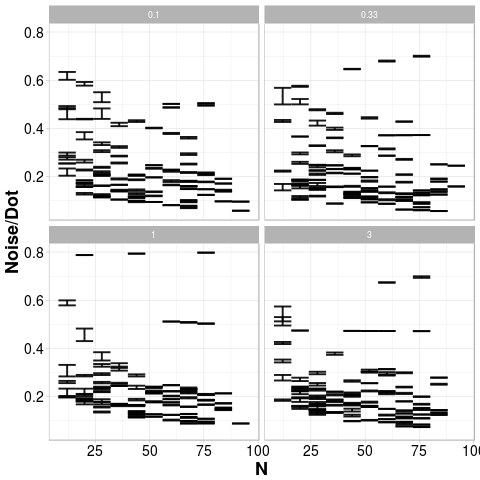

In [189]:
%%R -i sum_vals summary

sum_vals <- sum_vals %>%
            mutate(time_num=Time) %>%
             mutate(t=log(Time)) %>%
            mutate(Time=as.factor(Time)) %>%
            mutate(pct_seen=seen/Dots_Shown) %>%
           # mutate(t=Time) %>%
          #  mutate(real_weber=exp(pct_seen * seen_noise + noise)) %>%
            # mutate(real_slope=exp(pct_seen * seen_slope + slope)) %>%
           # mutate(real_weber=weber) %>%
           # mutate(real_slope=slope) %>%(
            mutate(guess=a_slope * Dots_Shown ** k_slope) %>%
            mutate(noise=a_noise * guess ** k_noise) %>%
            mutate(guess_pd = guess/Dots_Shown) %>%
            mutate(noise_pd = noise/Dots_Shown) %>%

           # mutate(guess=real_slope*Dots_Shown) %>%
           # mutate(noise=real_weber*guess) %>%
        
            mutate(err=Dots_Counted - Dots_Shown) %>%
            mutate(pct_err=err/Dots_Shown) %>%
            group_by(pid, Time) %>%
            mutate(min_n = min(Dots_Shown)) %>%
            rowwise() %>%
            mutate(guess_start = guess*(Dots_Shown == min_n)) %>%
            mutate(noise_start = noise*(Dots_Shown == min_n)) %>%
            group_by(pid, Time) %>%
            mutate(guess_start = guess - max(guess_start)) %>%
            mutate(noise_start = noise - max(noise_start)) %>%
            mutate(guess_start_pd = guess_start/Dots_Shown) %>%
            mutate(noise_start_pd = noise_start/Dots_Shown) %>%

            ungroup



p.1 <- ggplot(data=sum_vals, aes(x=a_slope, y=k_slope)) +
        stat_summary() +
        geom_line(aes(group=pid)) +

        paper_theme_2 + theme(strip.text=element_blank()) 


p.2 <- ggplot(data=sum_vals, aes(x=time_num, y=guess_pd)) +
       # geom_line() +
        stat_summary(color="red") +

        stat_summary(geom="line",aes(group=pid)) +

        paper_theme_2 + theme(strip.text=element_blank())  +

      geom_hline(yintercept=1, size=1.5, linetype="dotted") +
      paper_theme_2 + 
      xlab("Time") + ylab("Slope")

p.3 <- ggplot(data=sum_vals, aes(x=Time, y=noise_pd)) +
       # geom_line() +
        stat_summary(color="red") +

        stat_summary(geom="line",aes(group=pid)) +

        paper_theme_2 + theme(strip.text=element_blank())  +

      #geom_hline(yintercept=1, size=1.5, linetype="dotted") +
      paper_theme_2 + 
      xlab("Time") + ylab("Noise")

p.4 <- ggplot(data=sum_vals, aes(x=Dots_Shown, y=noise_pd, group=pid)) +
        #geom_point(alpha=0.2) +
       # geom_line() +
        #stat_smooth(method="lm", se=FALSE, formula=y~log(x)) +

     #   stat_smooth(method="lm")
      # stat_summary_bin(binwidth=5,fun.y="mean", 
                        #geom="line", size=0.9, width=0.2,alpha=0.9 ) +

       stat_summary_bin(binwidth=8, fun.data="mean_se", geom="errorbar", size=0.9, width=0.2,alpha=0.9 ) +

        #stat_summary(geom="line", size=0.5, alpha=0.5) +

        paper_theme_2 + theme(strip.text=element_blank())  +

      #geom_hline(yintercept=1, size=1.5, linetype="dotted") +
      paper_theme_2 + 
      xlab("N") + ylab("Noise/Dot")   + facet_wrap(~Time)

print(p.4)
